# NHANES 2017-March 2020 Pre-pandemic

Documentation: https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?Cycle=2017-2020 /
Diabetes Questionnaire: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DIQ.htm


Data collected from 2019 to March 2020 were combined with data from the NHANES 2017-2018 cycle to form a nationally representative sample of NHANES 2017-March 2020 pre-pandemic data.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from features import replace_nan_with_x, replace_values_with_nan, diabetes_name_mapping

Retrieving Necessary Dataframes and seperating diabetes and non-diabetes dataframe

In [12]:
df = pd.read_sas('P_DIQ.XPT')
df_demo= pd.read_pickle('demo_clean.pkl')
df_A1c= pd.read_sas('P_GHB.XPT')
df_fstng_glc= pd.read_sas('P_GLU.XPT')

In [13]:
#creating dataframe with patients above 20, only diabetic. no diabetes is also separated.
df_no_diabetes = df[df['DIQ010'].isin([2,3,9])]
df_diabetes = df[df['DIQ010'].isin([1])]

Feature Engineering
1. Dealing with missing values
2. Standardising values
2. Renaming columns


In [14]:
#Listing the missing values

df_diabetes_name= df_diabetes.rename(columns=diabetes_name_mapping)
df_diabetes_name= df_diabetes_name.filter(diabetes_name_mapping.values(), axis=1)

total_rows = df_diabetes_name.shape[0]

print("Total rows in the DataFrame:", total_rows)

print(df_diabetes_name.isnull().sum().sort_values(ascending=False))



Total rows in the DataFrame: 1445
pre-diabetes                1445
insulin_unit_month          1027
insulin_Duration            1018
last_A1c                     227
retinopathy                   11
diabetes_age                   2
diabetes_specialist_year       2
seeing_specialist              2
SEQN                           0
diabetes                       0
insulin                        0
medication                     0
dtype: int64


In [15]:
#Function to clean diabetes and non-diabetic dataframe

def preprocess_diabetes_data(df_main, df_A1c, df_fstng_glc, df_demo, diabetes_name_mapping):
    # Define columns and values to replace
    column_na_7_9 = ['DIQ010', 'DIQ160', 'DIQ050', 'DIQ070', 'DIQ230', 'DIQ240', 'DIQ080']
    column_na_777_999 = ['DID040', 'DID060', 'DIQ280']
    column_na_7777_9999 = ['DIQ300S', 'DIQ300D', 'DID320', 'DID341']

    # Replace values with NaN
    for columns_to_replace, values_to_replace in [(column_na_7_9, [7, 9]),
                                                  (column_na_777_999, [777, 999]),
                                                  (column_na_7777_9999, [7777, 9999])]:
        df_main = replace_values_with_nan(df_main, columns_to_replace, values_to_replace)

    # Merge dataframes
    df_main = df_main.merge(df_A1c, on='SEQN', how='left')
    df_main = df_main.merge(df_fstng_glc, on='SEQN', how='left')
    
    # Rename columns
    df_main.rename(columns=diabetes_name_mapping, inplace=True)
    df_main = df_main.filter(diabetes_name_mapping.values(), axis=1)

    # Standardize insulin_Duration values
    df_main['insulin_Duration'] = df_main.apply(
        lambda row: round(row['insulin_Duration'] / 12, 2) if row['insulin_unit_month'] == 2 else row[
            'insulin_Duration'],
        axis=1
    )
    df_main.loc[df_main['insulin'] == 2, 'insulin_Duration'] = 0
    df_main.loc[df_main['insulin'] == 666, 'insulin_Duration'] = 1

    #fill missing A1c values based on memory
    df_main['lab_A1c'].fillna(df_main['last_A1c'], inplace=True)

    # Drop unnecessary columns
    df_main = df_main.drop(columns=['insulin_unit_month', 'last_A1c'])

    # Convert selected columns into categorical
    format_to_categorical = ['insulin', 'medication', 'seeing_specialist', 'retinopathy']

    if (df_main['diabetes'] == 1).any():
        # Your code to execute if 'diabetes' has a value of 1
        df_main[format_to_categorical] = df_main[format_to_categorical].astype(str)
        df_main['pre-diabetes'] = df_main['pre-diabetes'].fillna(3)
    #merge with demographic dataframe
    df_main = df_main.merge(df_demo, on='SEQN', how='left')
    

    return df_main

df_diabetes= preprocess_diabetes_data(df_diabetes, df_A1c,  df_fstng_glc,df_demo, diabetes_name_mapping)
df_no_diabetes= preprocess_diabetes_data(df_no_diabetes, df_A1c,  df_fstng_glc,df_demo, diabetes_name_mapping)

In [16]:
#removing the missing values in diabetic dataframe

total_rows = df_diabetes.shape[0]
print("Total rows in the DataFrame:", total_rows)
print(df_diabetes.isnull().sum().sort_values(ascending=False))


df_diabetes = df_diabetes.dropna(subset=[ 'lab_A1c', 'diabetes_age', 'diabetes_specialist_year',
                                           'Interview_Status','Marital_Status', 'Education_20+', 'Birth_Country', 
                                           'Race', 'Age_Years', 'RatioIncome_Poverty', 'Gender', 'insulin_Duration'])

total_rows = df_diabetes.shape[0]
print("Total rows in the DataFrame after removal:", total_rows)
print(df_diabetes.isnull().sum().sort_values(ascending=False))

Total rows in the DataFrame: 1445
LengthStay_US               1041
fasting_glucose              783
lab_A1c                       77
Marital_Status                28
Education_20+                 28
Birth_Country                 28
Race                          28
Age_Years                     28
Interview_Status              28
Gender                        28
RatioIncome_Poverty           28
diabetes_age                  18
diabetes_specialist_year      15
insulin_Duration               4
diabetes                       0
retinopathy                    0
seeing_specialist              0
medication                     0
insulin                        0
pre-diabetes                   0
SEQN                           0
dtype: int64
Total rows in the DataFrame after removal: 1313
LengthStay_US               946
fasting_glucose             678
SEQN                          0
Marital_Status                0
Education_20+                 0
Birth_Country                 0
Race                

In [17]:
#removing the missing values in non-diabetic dataframe

total_rows = df_no_diabetes.shape[0]
print("Total rows in the DataFrame:", total_rows)
print(df_no_diabetes.isnull().sum().sort_values(ascending=False))


df_no_diabetes = df_no_diabetes.dropna(subset=[ 'lab_A1c',
                                           'Interview_Status','Marital_Status', 'Education_20+', 'Birth_Country', 
                                           'Race', 'Age_Years', 'RatioIncome_Poverty', 'Gender'])

# Define a dictionary with column names and their corresponding fill values
fill_values = {
    'pre-diabetes': 2,
    'diabetes': 2,
    'diabetes_age': 0,
    'insulin_Duration': 0,
    'diabetes_specialist_year': 0,
    'insulin':2,
    'medication':2,
    'seeing_specialist': 2,
    'retinopathy':2

}

# Fill NaN values using the dictionary
df_no_diabetes.fillna(value=fill_values, inplace=True)

total_rows = df_no_diabetes.shape[0]
print("Total rows in the DataFrame after removal:", total_rows)
print(df_no_diabetes.isnull().sum().sort_values(ascending=False))

Total rows in the DataFrame: 13541
seeing_specialist           13541
retinopathy                 13541
diabetes_age                13541
insulin                     13541
insulin_Duration            13541
diabetes_specialist_year    13541
medication                  12309
LengthStay_US               11407
fasting_glucose              9459
Birth_Country                5751
Education_20+                5748
Marital_Status               5748
Gender                       5748
Interview_Status             5748
Age_Years                    5748
Race                         5748
RatioIncome_Poverty          5748
lab_A1c                      5078
pre-diabetes                 4041
diabetes                        8
SEQN                            0
dtype: int64
Total rows in the DataFrame after removal: 6804
LengthStay_US               4917
fasting_glucose             3472
SEQN                           0
Marital_Status                 0
Education_20+                  0
Birth_Country            

In [18]:
df_diq = pd.concat([df_diabetes, df_no_diabetes], axis=0, ignore_index=False)

In [19]:
#Categorical Mapping

#renaming all the values in categorical column into appropriate values
marital_status_mapping = {1: 'Married/Partner', 2: 'Widow/Divorce', 3: 'Single'}
gender_mapping = {1: 'Male', 2: 'Female'}
race_mapping = {1: 'Mexican American', 2: 'Other Hispanic', 3: 'White', 4: 'Black', 6: 'Asian', 7: 'Other Race'}
birth_mapping = {1: 'USA', 2: 'Others'}
diabetes_mapping = {1: 'Yes', 2: 'No', 3:'Borderline'}
specialist_mapping = {1: 'Yes', 2: 'No'}
retinopathy_mapping  = {1: 'Yes', 2: 'No'}
insulin_mapping = {1: 'Yes', 2: 'No'}
medication_mapping  = {1: 'Yes', 2: 'No'}
prediabetes_mapping  = {1: 'Yes', 2: 'No', 3: 'Diabetic'}
education_mapping  = {1: '<9th grade', 2: '9th-11th grade', 3: 'High School', 4:'College', 5: 'College graduate'}

df_diq_label = df_diq.copy()
df_diq_label = df_diq_label.astype(float)
df_diq_label= df_diq_label.drop('SEQN', axis=1)
df_diq_label.replace({
    'Marital_Status': marital_status_mapping,
    'Gender': gender_mapping,
    'Race': race_mapping,
    'Birth_Country': birth_mapping,
    'diabetes': diabetes_mapping,
    'seeing_specialist': specialist_mapping,
    'retinopathy': retinopathy_mapping,
    'insulin': insulin_mapping,
    'medication': medication_mapping,
    'pre-diabetes': prediabetes_mapping,
    'Education_20+': education_mapping
}, inplace=True)

In [20]:
df_diq_label.head()

,diabetes,diabetes_age,pre-diabetes,insulin,insulin_Duration,medication,diabetes_specialist_year,seeing_specialist,retinopathy,lab_A1c,fasting_glucose,Gender,Interview_Status,Age_Years,Race,Birth_Country,LengthStay_US,Education_20+,Marital_Status,RatioIncome_Poverty
0,Yes,54.0,Diabetic,Yes,0.08,Yes,1.0,Yes,No,5.7,8.55,Male,2.0,68.0,Other Race,USA,NaN,4.0,Single,1.20
2,Yes,60.0,Diabetic,No,0.00,Yes,2.0,Yes,No,8.4,5.88,Female,2.0,68.0,Black,USA,NaN,5.0,Widow/Divorce,5.00
3,Yes,55.0,Diabetic,No,0.00,Yes,5.0,Yes,No,6.4,10.00,Male,2.0,58.0,Other Hispanic,USA,NaN,3.0,Widow/Divorce,1.60
4,Yes,52.0,Diabetic,No,0.00,Yes,4.0,Yes,No,8.7,NaN,Male,2.0,68.0,White,USA,NaN,1.0,Married/Partner,1.75
5,Yes,58.0,Diabetic,No,0.00,Yes,3.0,Yes,Yes,7.0,NaN,Female,2.0,62.0,Black,USA,NaN,3.0,Widow/Divorce,0.07


In [21]:
#seperating labeled columns into categorical and numerical dataframe
numeric_df = df_diq_label.select_dtypes(include=['float64', 'int64'])
categorical_df = df_diq_label.select_dtypes(exclude=['float64', 'int64'])

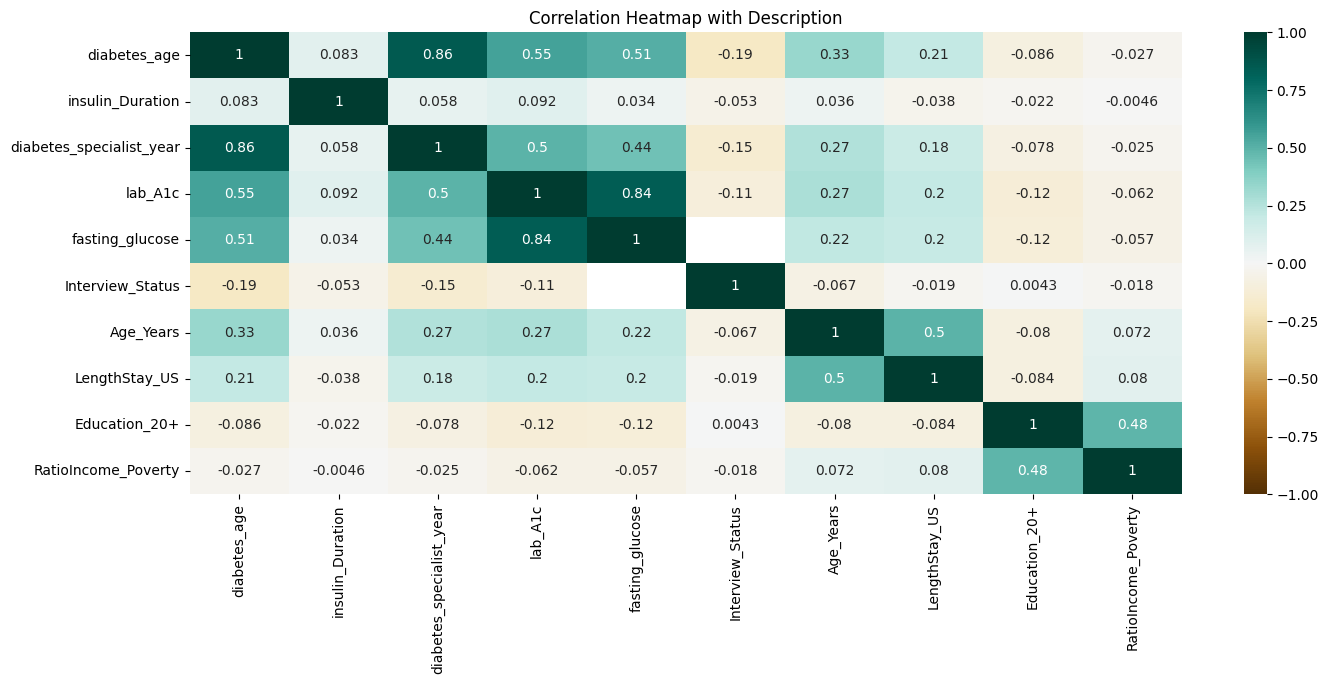

In [22]:
#Visualising the correlation of dataframe with numerical dataframe

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(numeric_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.title('Correlation Heatmap with Description') 
plt.show()
#plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [23]:
#Listing the correlation of dataframe with numerical dataframe

from itertools import product
from scipy.stats import chi2_contingency

categorical_df = df_diq_label.select_dtypes(exclude=['float64', 'int64'])
categorical_list= categorical_df.columns
categorical_list2= categorical_list.copy()
cat_var_prod = list(product(categorical_list,categorical_list2, repeat = 1))


result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(chi2_contingency(pd.crosstab(
                            df_diq_label[i[0]], df_diq_label[i[1]])))[0]))
        
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 
                                                       'coeff'])

chi_test_output['coeff'] = chi_test_output['coeff'].round(3)

# Using pivot function to convert the above DataFrame into a crosstab
result_pivot = chi_test_output.pivot(index='var1', columns='var2', values='coeff')

# Print the rounded result
print(result_pivot)


var2               Birth_Country   Gender  Marital_Status      Race  diabetes  \
var1                                                                            
Birth_Country                NaN    2.204         238.352  4118.429     6.145   
Gender                     2.204      NaN         134.753    12.053    28.366   
Marital_Status           238.352  134.753             NaN   463.774   117.688   
Race                    4118.429   12.053         463.774       NaN    35.018   
diabetes                   6.145   28.366         117.688    35.018       NaN   
insulin                    3.852    6.475          24.335    15.593  2105.846   
medication                12.667   16.274          94.580    14.341  4961.125   
pre-diabetes              12.773   41.732         137.151    38.792  8157.597   
retinopathy                1.264    0.969          32.641     3.552  1380.369   
seeing_specialist          0.007    7.469          70.911     2.872  6007.294   

var2                insulin

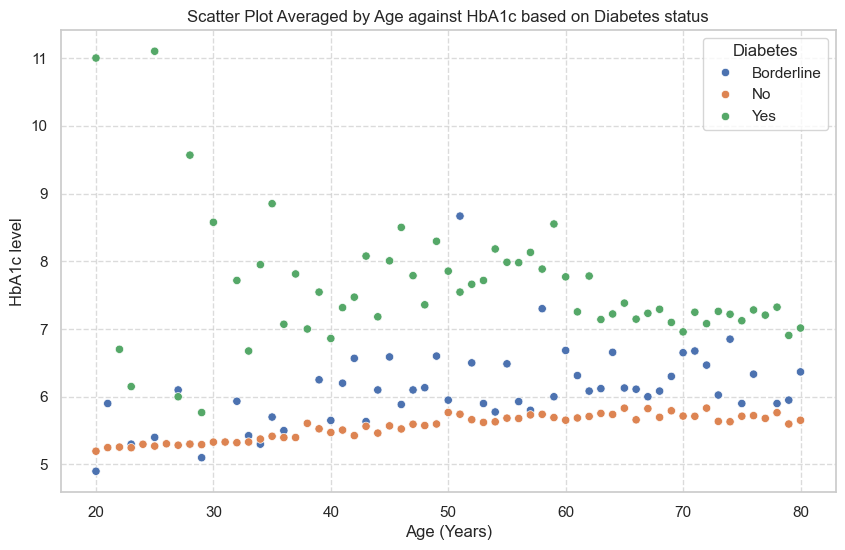

In [24]:


# Group by 'Age_Years' and 'Education_20+', calculate the mean for 'RatioIncome_Poverty'
grouped_data = df_diq_label.groupby(['Age_Years', 'diabetes'])['lab_A1c'].mean().reset_index()

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a scatter plot with color grouping
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='Age_Years', y='lab_A1c', hue='diabetes', data=grouped_data, palette='deep', marker='o')

# Set axis labels and title
plt.xlabel('Age (Years)')
plt.ylabel('HbA1c level')
plt.title('Scatter Plot Averaged by Age against HbA1c based on Diabetes status')

# Add legend
plt.legend(title='Diabetes')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

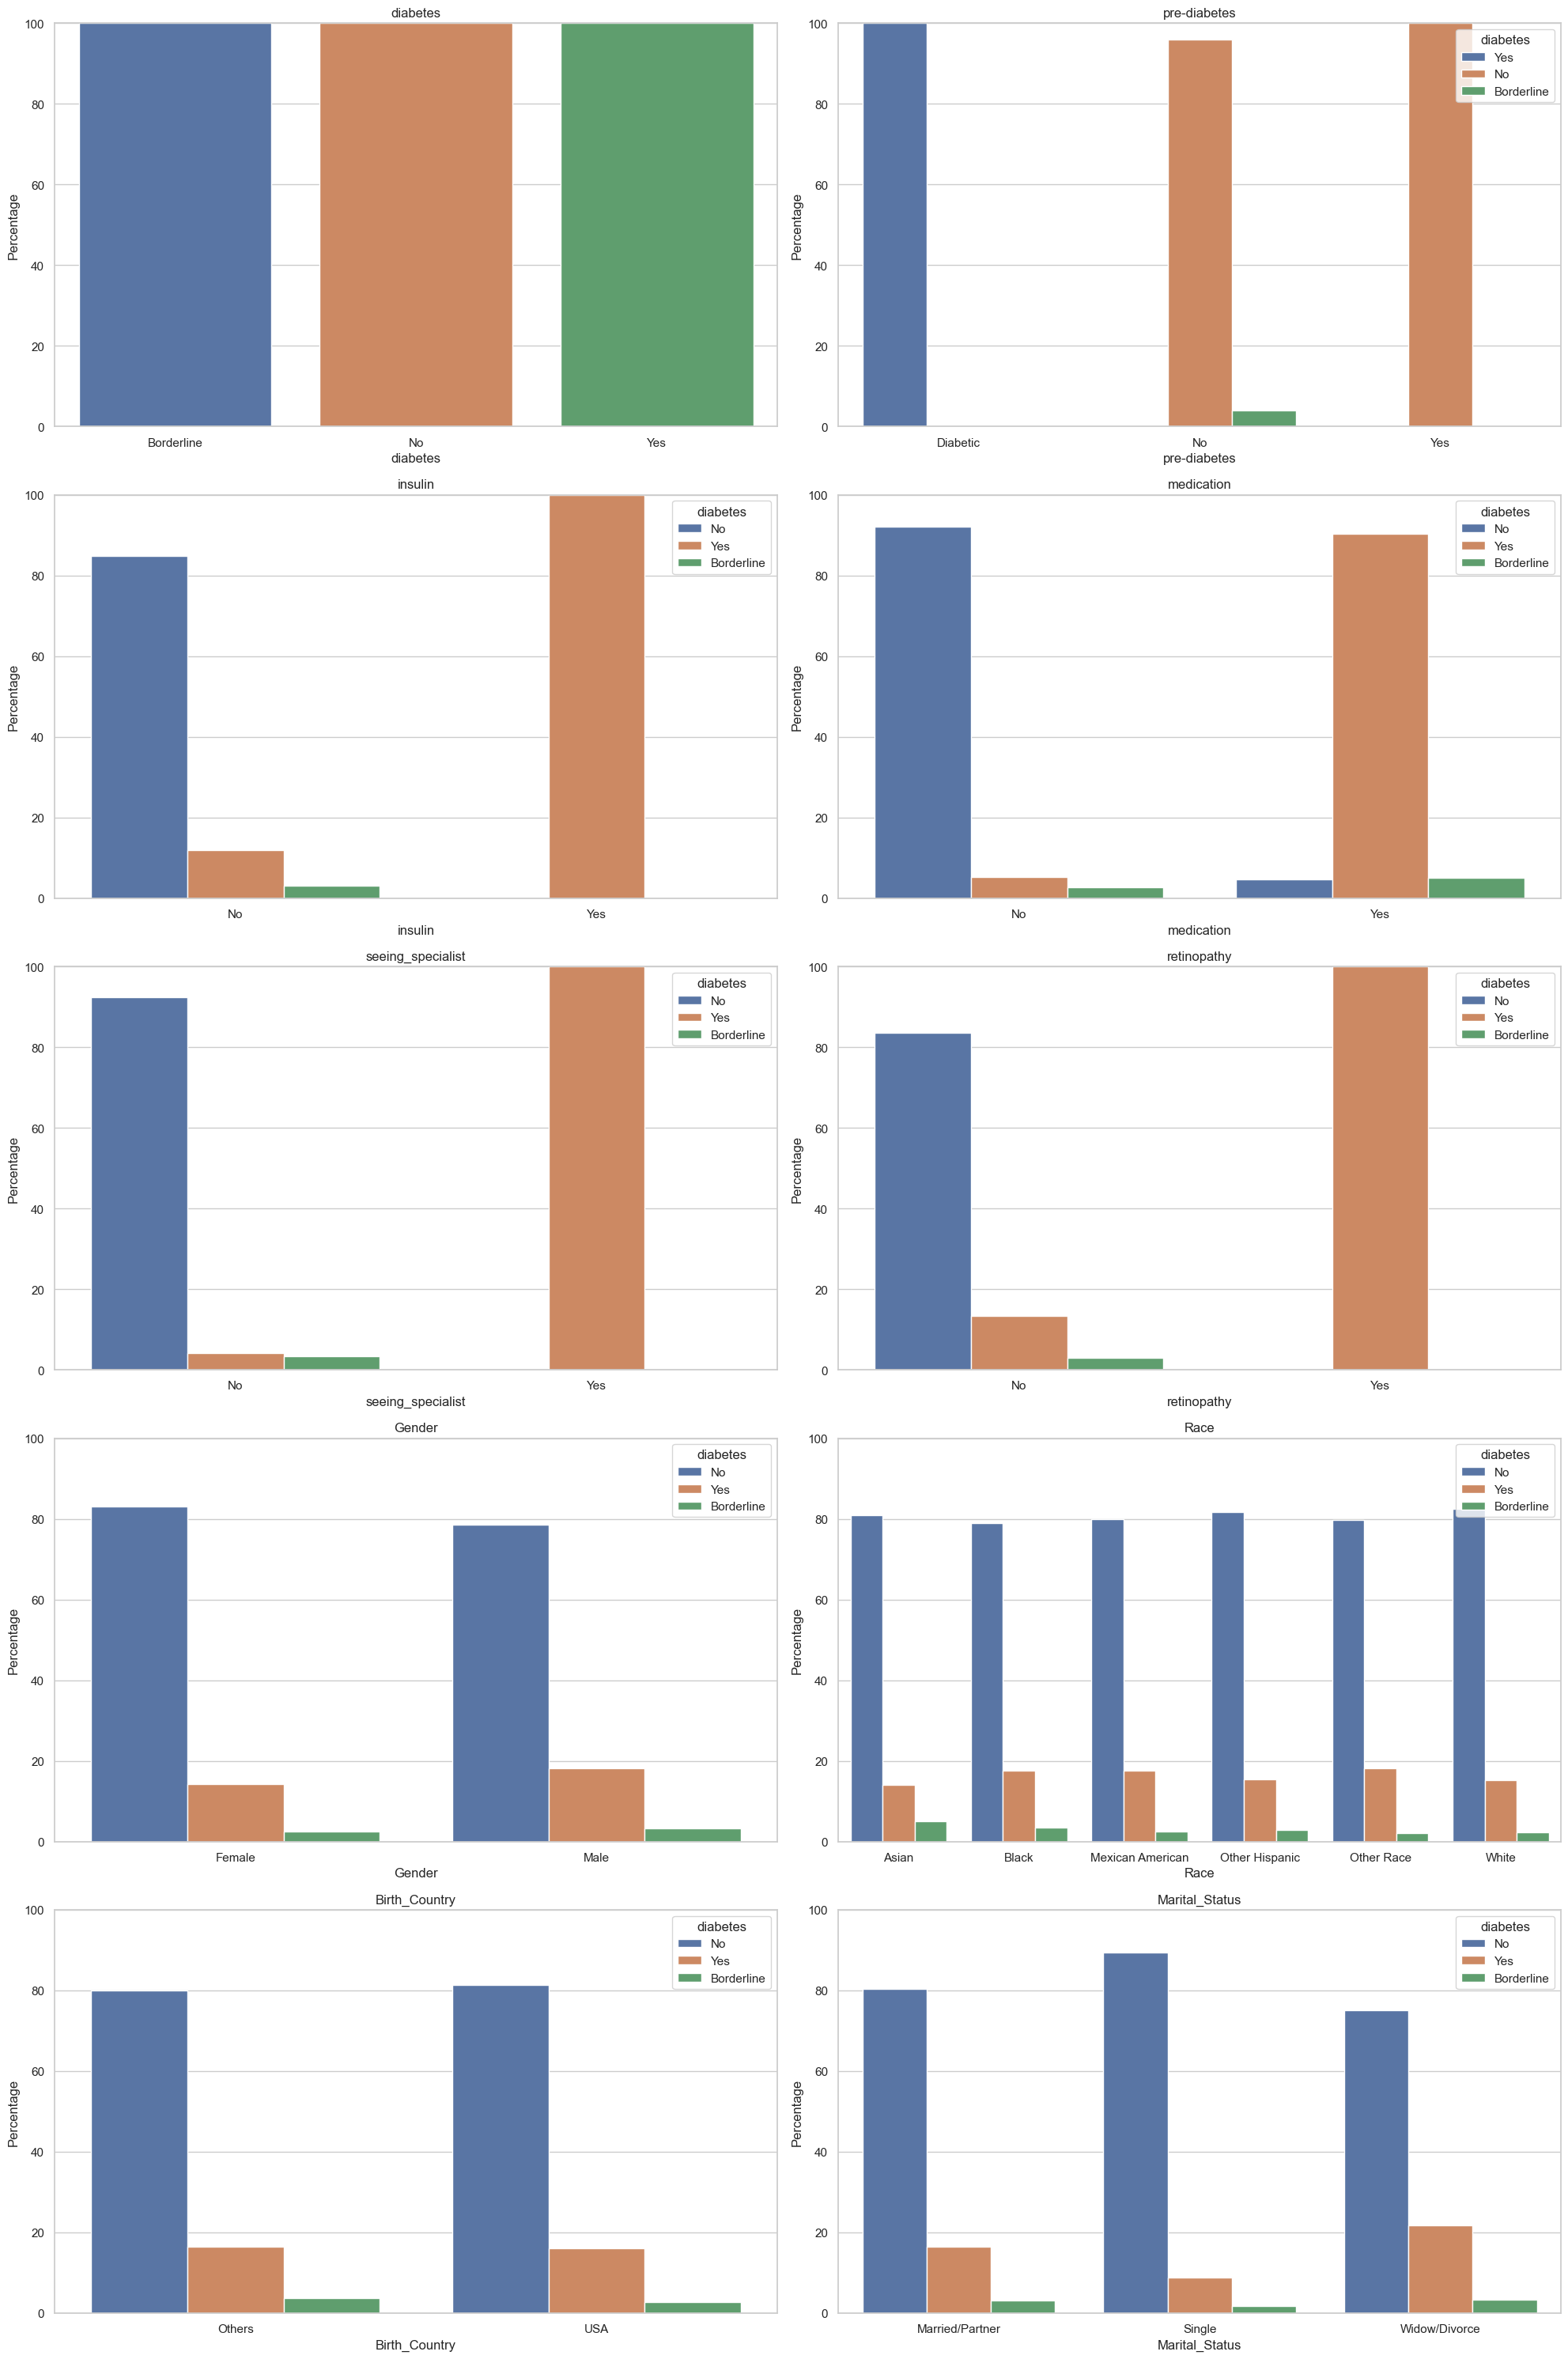

In [26]:
# Reset index of the labeled dataframe
df_diq_label.reset_index(drop=True, inplace=True)

# Assuming categorical_list contains unique column names
selected_columns = categorical_list

# Set up the subplot grid
row_num = 5
col_num = 2
fig, axes = plt.subplots(row_num, col_num, squeeze=False, figsize=(20, 30))

# Iterate through selected columns and create percentage plots
for ix, col in enumerate(selected_columns):
    row_n, col_n = divmod(ix, col_num)
    
    # Calculate percentages for each category
    percentages = df_diq_label.groupby(col)['diabetes'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

    sns.barplot(x=col, y='Percentage', hue='diabetes', data=percentages, ax=axes[row_n, col_n])
    axes[row_n, col_n].set_title(col)
    axes[row_n, col_n].set_ylim(0, 100)  # Set y-axis limit to 100 for percentages

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

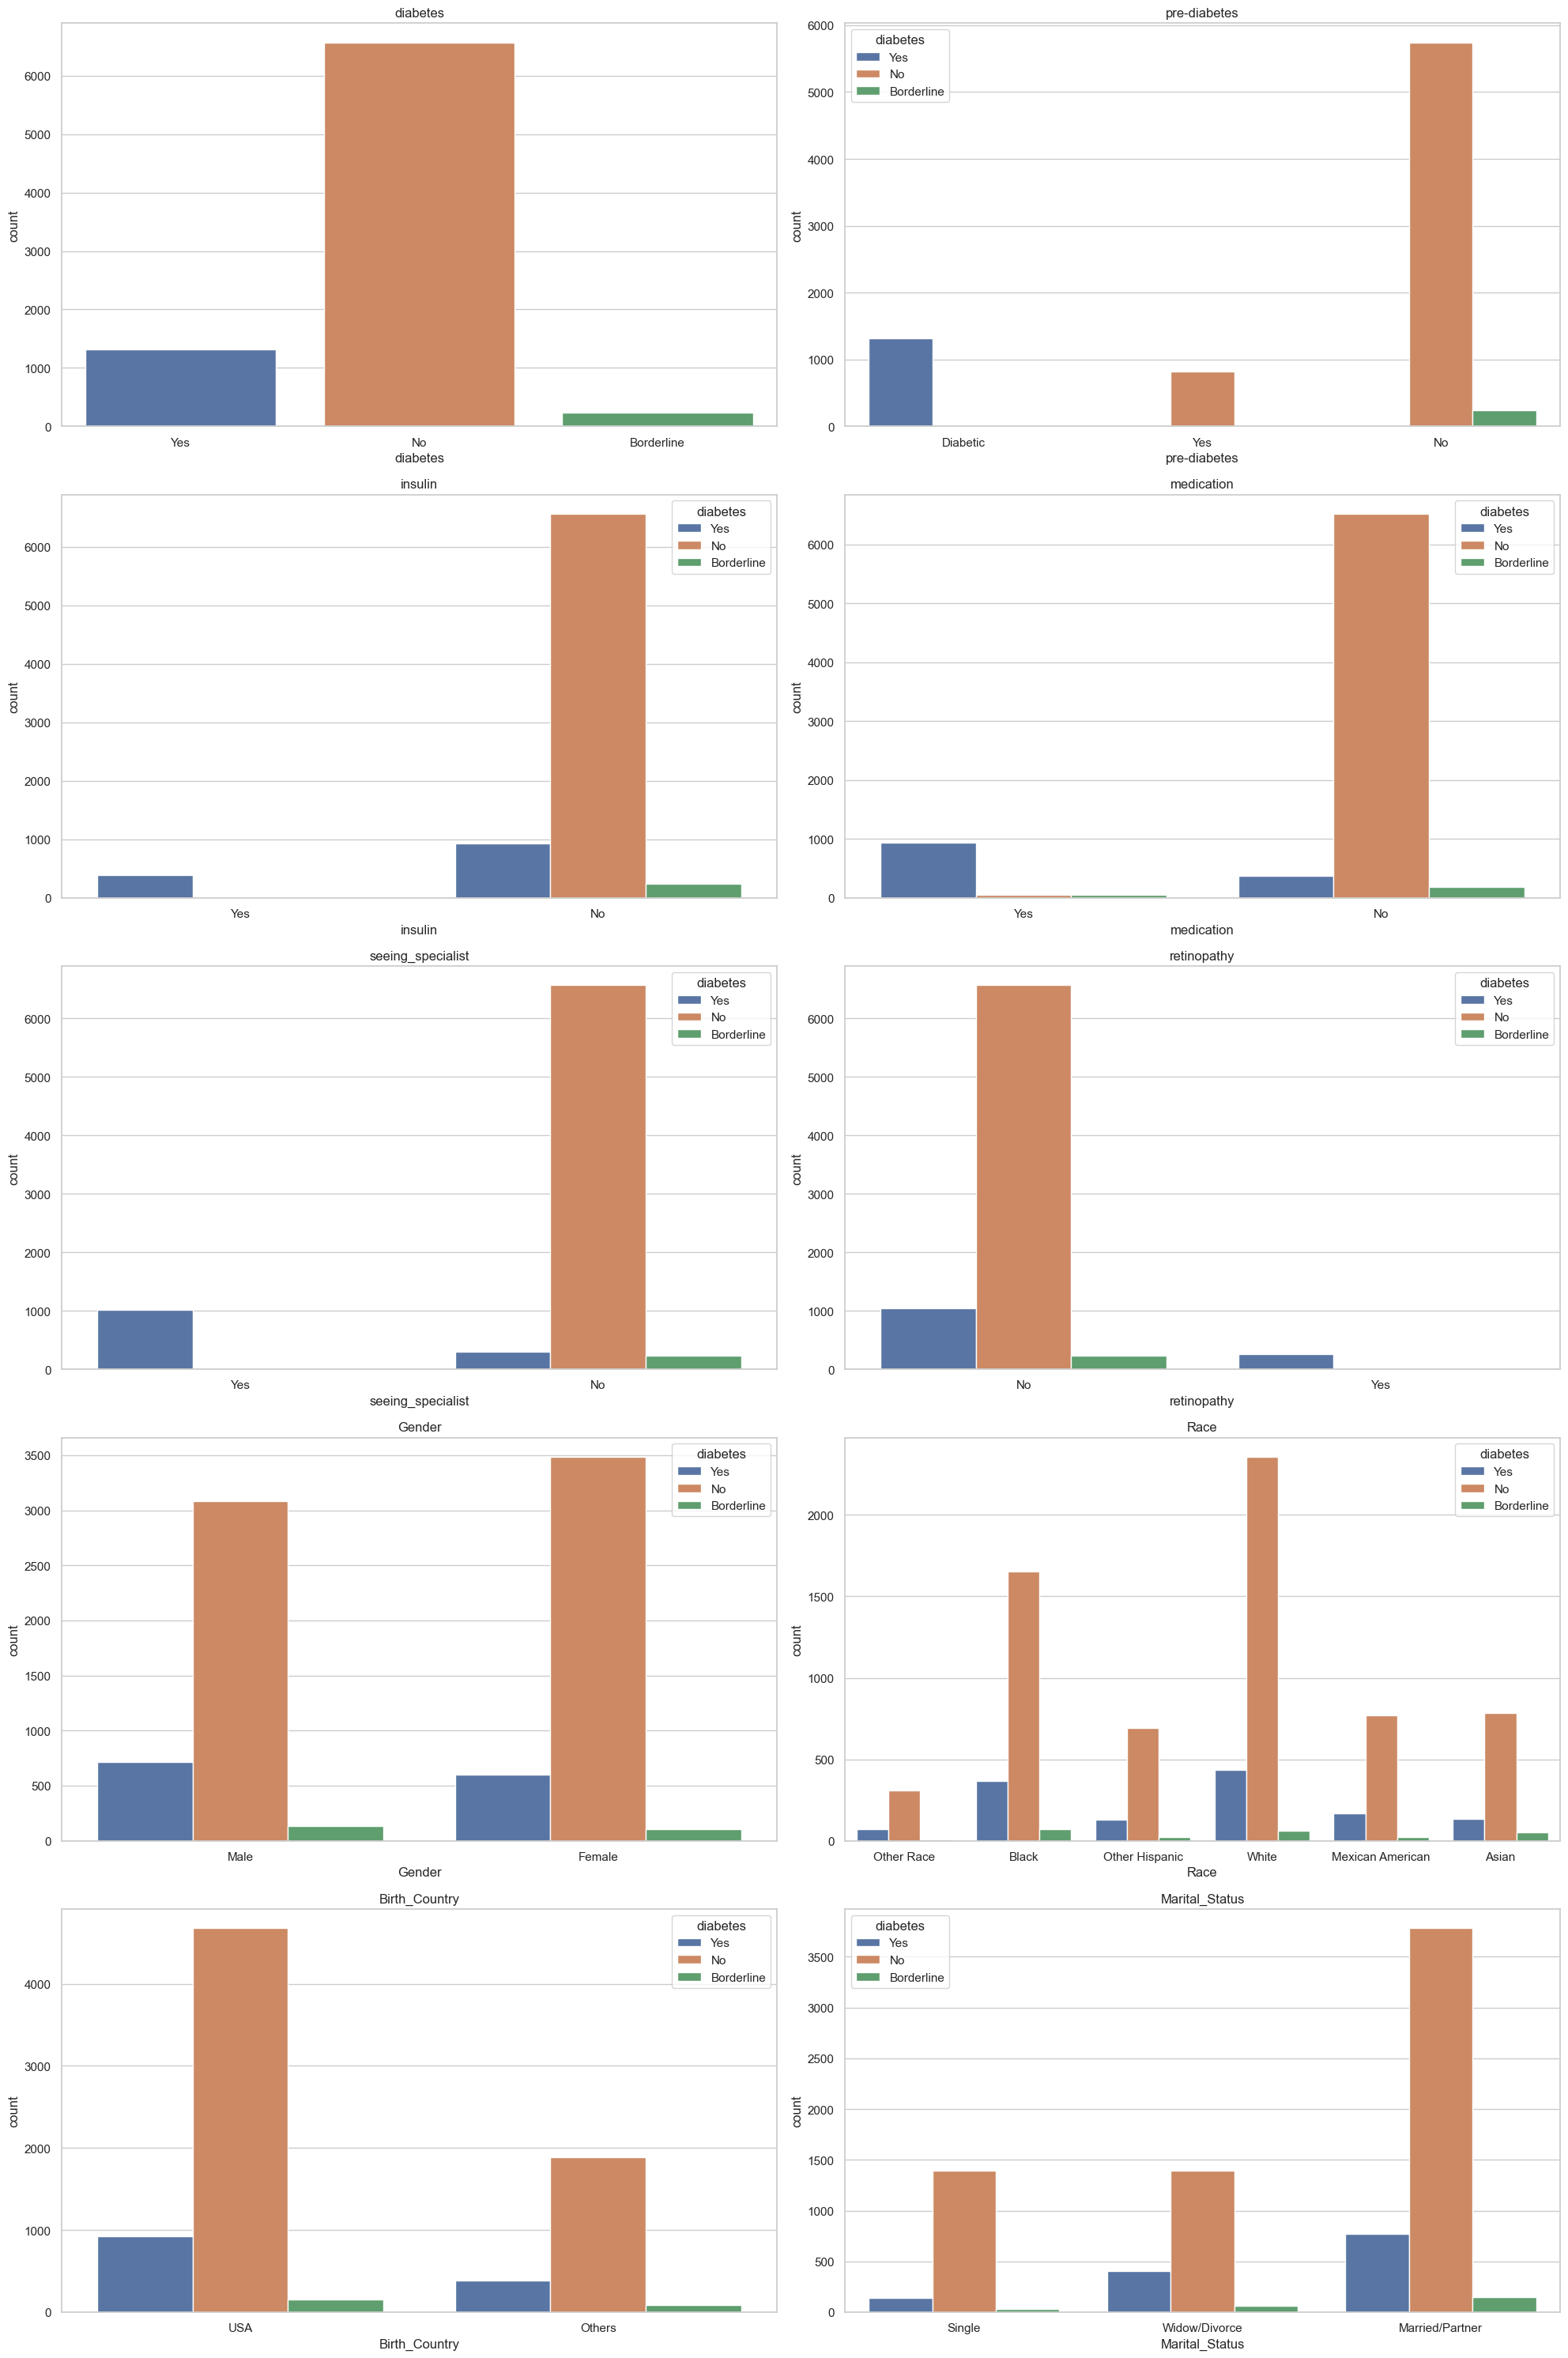

In [25]:
#Reset index of the labeled dataframe
df_diq_label.reset_index(drop=True, inplace=True)
# Assuming categorical_list contains unique column names
selected_columns = categorical_list

# Set up the subplot grid
row_num = 5
col_num = 2
fig, axes = plt.subplots(row_num, col_num, squeeze=False, figsize=(20, 30))

# Iterate through selected columns and create count plots
for ix, col in enumerate(selected_columns):
    row_n, col_n = divmod(ix, col_num)
    sns.countplot(x=col, hue='diabetes', data=df_diq_label, ax=axes[row_n, col_n])
    axes[row_n, col_n].set_title(col)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df_diq.head()

In [ ]:
csv_filename = 'diq_clean.pkl'
df_diq.to_pickle(csv_filename)